Start with importing everything that will be needed for this notebook.

In [1]:
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario
from ema_workbench.em_framework.optimization import EpsilonProgress
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
from ema_workbench import Policy
import seaborn as sns
from ema_workbench import save_results
from ema_workbench import ScalarOutcome


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


This imports the model with our chosen problem formulation. It also adds a reference scenario for the mordor analysis which includes the normal values from the model.

In [2]:
model, planning_steps = get_model_for_problem_formulation(3)


reference_scenario = Scenario('reference', **{'A.0_ID flood wave shape': 4,
                                              'A.1_Bmax': 175, 'A.1_pfail': 0.5, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 175, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 175, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 175, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 175, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})


This sets the values for the analysis that will be done. A high epsilon was chosen because the model didn't want to converge with low epsilon, and took to long to converge

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 100000
epsilon = [0.5,] * len(model.outcomes)

Runs the analysis

In [4]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model) as evaluator:
    total = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon, reference= reference_scenario, convergence  = convergence_metrics )

[MainProcess/INFO] pool started with 8 workers
1099it [03:30,  5.23it/s]                                                      
[MainProcess/INFO] optimization completed, found 228 solutions
[MainProcess/INFO] terminating pool


Saves the results as a data frame.

In [5]:
df, convergence = total

In [6]:
print(len(df))

228


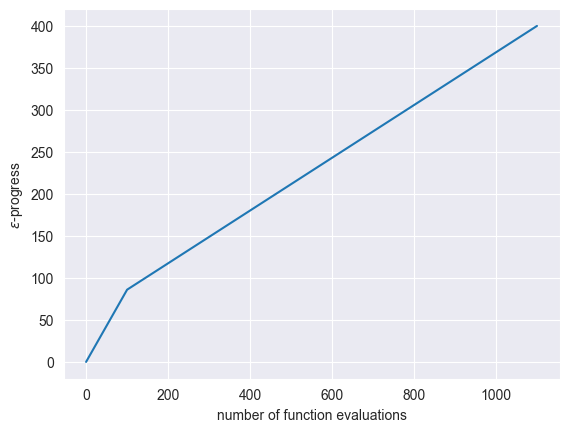

In [7]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

As can be seen it begins to slowly converge but not a lot, because of the many runs there could probably be played with it for better results

In [8]:
from ema_workbench import save_results
df, convergence = total


In [9]:
df['sum_deaths'] = df['A.1_Expected Number of Deaths'] + df['A.2_Expected Number of Deaths'] + df['A.3_Expected Number of Deaths'] + df['A.4_Expected Number of Deaths'] + df['A.5_Expected Number of Deaths']
df["sum_costs"]= df["A.3 Total Costs"] + df["A.2 Total Costs"] + df["A.1 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

df.to_csv('MORDOR small.csv') #save as csv for quicker recovery later

Run parcoords with 4000+ policies

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


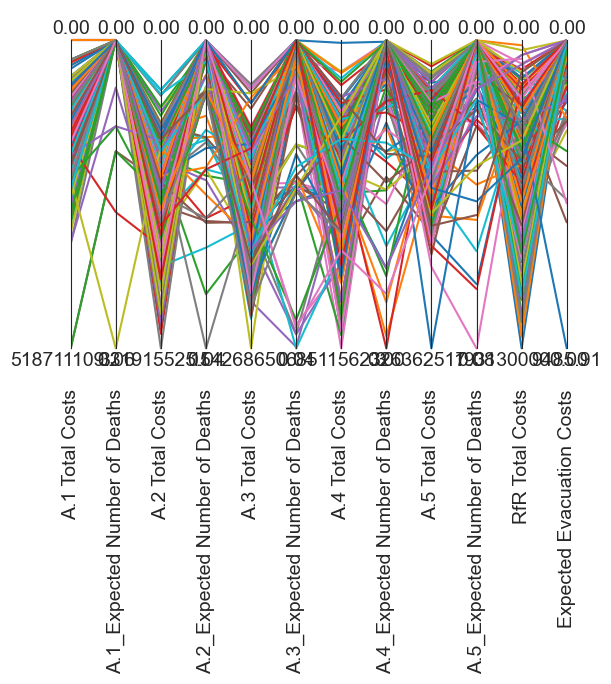

In [10]:
data = df.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0 #sets lower bound to zero
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns) #reverses the x because minimizing is the goal
plt.show()

In [11]:
df = pd.read_csv('MORDOR small.csv')  # reads the csv

limiting = (df.sum_deaths < 0.0001) & (df.sum_costs < 450000000) # finds policies with low death and cost
np.sum(limiting) # counts the amount of policies with those limits


4

Repeats the parcoords  plot with less policies for a clearer view

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


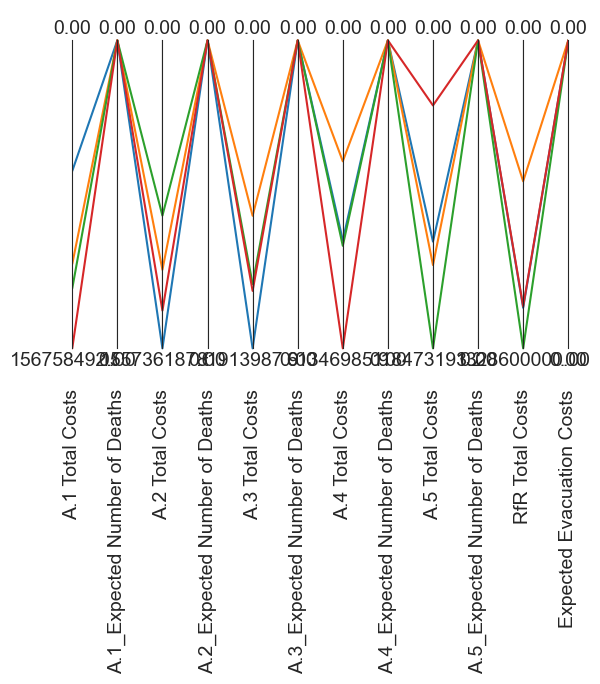

In [12]:
data = df[limiting].loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, limits.columns] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(limits.columns)
plt.show()

In [13]:
df[limiting]
display(df[limiting]) # displays the policies and results

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,sum_deaths,sum_costs
28,28,0,0,1,1,0,1,0,0,0,...,8.191399e+07,0.0,3.981657e+07,0.0,7.740447e+07,0.0,1.153600e+09,0.0,0.0,4.213782e+08
55,55,1,1,0,0,0,0,1,0,1,...,4.665017e+07,0.0,2.409222e+07,0.0,8.642097e+07,0.0,6.079000e+08,0.0,0.0,3.869980e+08
88,88,0,1,0,1,1,1,1,1,1,...,6.483599e+07,0.0,4.091686e+07,0.0,1.184732e+08,0.0,1.328600e+09,0.0,0.0,4.390876e+08
168,168,0,0,0,1,0,1,1,1,1,...,6.662956e+07,0.0,6.134699e+07,0.0,2.503721e+07,0.0,1.147400e+09,0.0,0.0,4.464109e+08


In [14]:
policy_advice = df[limiting]
policies = policy_advice.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns= ["sum_deaths"])
policies = policies.drop(columns= ["sum_costs"])
display(policies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
28,28,0,0,1,1,0,1,0,0,0,...,0,6,1,1,6,7,1,6,0,3
55,55,1,1,0,0,0,0,1,0,1,...,0,3,0,1,4,6,0,7,0,4
88,88,0,1,0,1,1,1,1,1,1,...,2,0,7,3,7,5,3,6,3,3
168,168,0,0,0,1,0,1,1,1,1,...,3,0,6,5,7,7,9,1,0,0


In [15]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

Does a scenario analysis from those 8 policies


In [16]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
100%|██████████████████████████████████████| 4000/4000 [12:58<00:00,  5.14it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
save_results(results, 'Mordor_policy_final_results')
experiments, outcomes = results

[MainProcess/INFO] results saved successfully to /Users/tp/epa advanced sim/final assignment/Mordor_policy_final_results


In [18]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = np.mean(value)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
means = pd.DataFrame.from_dict(overall_scores).T
means

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
168,1.595513e+08,0.001709,1.480507e+08,0.010410,8.232458e+07,0.025059,6.136771e+07,0.000011,4.502095e+07,0.017633,1.147400e+09,0.000000
28,7.797282e+07,0.002848,1.576785e+08,0.000668,8.979661e+07,0.004826,3.995866e+07,0.000025,8.189567e+07,0.001480,1.153600e+09,438.977884
55,1.369932e+08,0.015673,1.181369e+08,0.002001,6.612035e+07,0.032187,2.502789e+07,0.000446,8.863900e+07,0.002051,6.079000e+08,0.000000
88,1.279244e+08,0.000133,1.071665e+08,0.002564,8.475054e+07,0.004797,4.095840e+07,0.000003,1.191476e+08,0.000089,1.328600e+09,1752.779671


In [19]:

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [20]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
168,7.029547e+15,4.201637e-05,6.442807e+15,0.000381,5.465966e+15,0.002531,1.207403e+13,1.078744e-09,2.323417e+15,7.571286e-04,0.0,0.000000e+00
28,9.414152e+15,8.534180e-05,1.778722e+15,0.000002,5.750740e+15,0.000176,3.644660e+13,4.034152e-09,1.654846e+15,9.572345e-06,0.0,7.520914e+05
55,1.758990e+16,1.304132e-03,1.507975e+15,0.000021,7.494868e+15,0.005487,8.981149e+13,7.072331e-07,1.090908e+15,2.270937e-05,0.0,0.000000e+00
88,4.261418e+15,3.219543e-07,6.747009e+15,0.000021,6.361639e+15,0.000082,1.821815e+13,9.952290e-11,6.236233e+14,5.981623e-08,0.0,7.292414e+06


Noise parcoords

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ema_workbench/analysis/parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


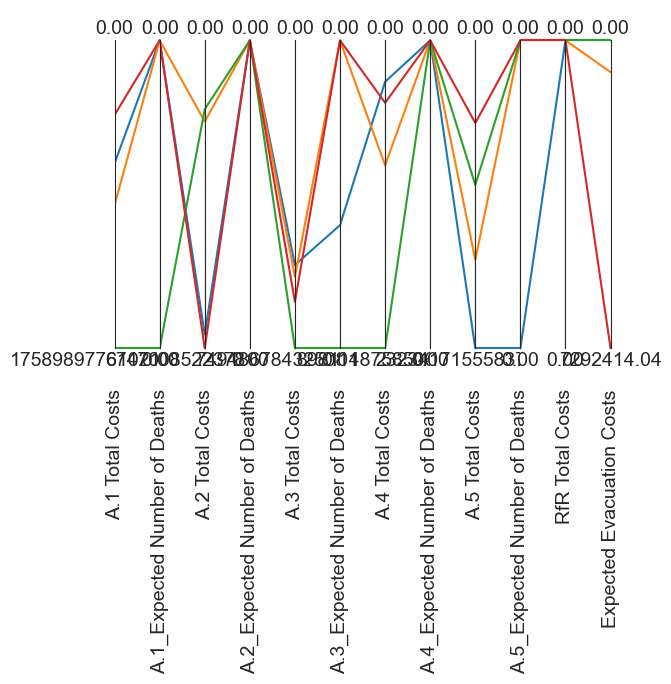

In [21]:
data = scores.round(3)
limits = parcoords.get_limits(data)
limits.loc[0, data.columns] = 0


paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis(scores.columns)
plt.show()

In [22]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [23]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


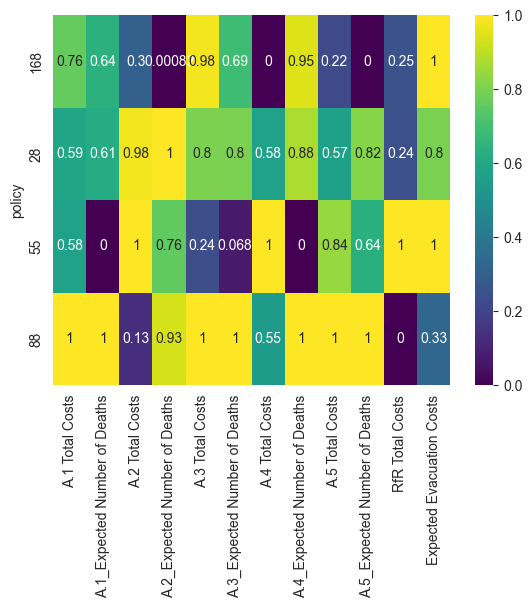

In [24]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [25]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

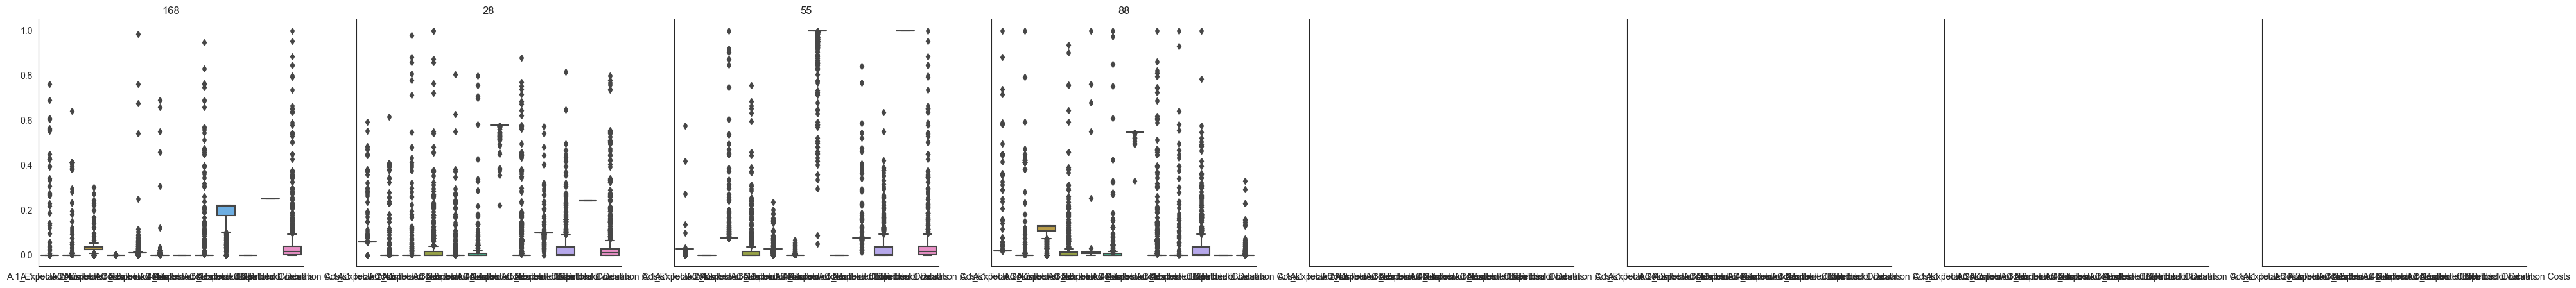

In [26]:
# this generates plots for the 8 policies with a shared y and x axis
fig, axes = plt.subplots(ncols=8, figsize=(50,5),
                         sharey=True, sharex=True)
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    sns.despine()
    ax.set_title(str(policy))
plt.savefig('8.png')
plt.show()

In [27]:
display(policies)

,Unnamed: 0,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
28,28,0,0,1,1,0,1,0,0,0,...,0,6,1,1,6,7,1,6,0,3
55,55,1,1,0,0,0,0,1,0,1,...,0,3,0,1,4,6,0,7,0,4
88,88,0,1,0,1,1,1,1,1,1,...,2,0,7,3,7,5,3,6,3,3
168,168,0,0,0,1,0,1,1,1,1,...,3,0,6,5,7,7,9,1,0,0
